In [1]:
import gensim
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import PorterStemmer
import time

In [2]:
def load_stop():
    f = open('./nfcorpus/raw/stopwords.large', 'r', encoding='utf-8')
    stopwords = [word.replace('\n','') for word in f.readlines()]
    return stopwords

stopwords = load_stop()

In [3]:
stemmer = PorterStemmer()

def load_data(path):
    files = open(path, 'r', encoding='utf-8')
    raw_docs = files.readlines()
    raw_docs = [doc.replace('\t', ' ').replace('\n', '').split() for doc in raw_docs]
    title = []
    docs = []
    
    for doc in raw_docs:
        title.append(doc[0])
        content = " ".join(doc[1:])
        content = gensim.utils.simple_preprocess(content)
        content = [non_stopword for non_stopword in content if non_stopword not in stopwords]
        content = [stemmer.stem(word) for word in content]
        docs.append(content)

    return np.array(docs), np.array(title)

### Tập train

In [4]:
docs, docs_title = load_data('./nfcorpus/train/train.docs')

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
queries, queries_title = load_data('./nfcorpus/train/train.all.queries')

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

In [8]:
tfidf = gensim.models.TfidfModel(corpus, smartirs='npu')
corpus_tfidf = tfidf[corpus]

In [15]:
lsi = gensim.models.LsiModel(corpus_tfidf, num_topics=1500)
index = gensim.similarities.MatrixSimilarity(lsi[corpus_tfidf])

In [10]:
fqrel = open('./nfcorpus/train/train.3-2-1.qrel', 'r', encoding='utf-8')
qrel = []
for f in fqrel.readlines():
    content = f.replace('\t', ' ').replace('\n', '').split()
    qrel.append([content[0], content[2]])

groundtruth = [[] for i in range(len(queries))]
groundtruth_title = []
for i in qrel:
    if i[0] not in groundtruth_title:
        groundtruth_title.append(i[0])
    element = groundtruth_title.index(i[0])
    groundtruth[element].append(i[1])


In [6]:
def Calculate_AP(retrieval, query):
    precision = 0
    precision_list = []
    recall_list = []

    for i in range(len(retrieval)):
        if retrieval[i] in query:
            precision += 1
            precision_list.append(float(precision)/(i+1))
            recall_list.append(float(precision)/len(query))

    temp = 0
    for i in range(len(precision_list)-1,-1,-1):
        if temp >= precision_list[i]:
            precision_list[i] = temp
        elif temp < precision_list[i]:
            temp = precision_list[i]
    
    precision_list_11 = []
    for i in range(11):
        for j in range(len(recall_list)):
            if recall_list[j] >= (i/10):
                precision_list_11.append(max(precision_list[j:]))
                break
    if len(precision_list_11) < 11:
        precision_list_11 += [0]*(11-len(precision_list_11))

    return sum(precision_list_11)/len(precision_list_11)

def mAP(rank, qrel_truth, qrel_truth_title, qrel_title ):
    mAP = []
    for i in range(len(rank)):
        element = qrel_truth_title.index(qrel_title[i])
        ap = Calculate_AP(rank[i], qrel_truth[element])
        mAP.append(ap)
    return np.mean(np.array(mAP))

In [7]:
def ranking(_lsi, _index, queries):
    all_rank = []
    for query in queries:
        new_vec = dictionary.doc2bow(query)
        vec_tfidf = tfidf[new_vec]
        vec_lsi = _lsi[vec_tfidf]
        sims = _index[vec_lsi]
        rank = np.argsort(sims)[::-1]
        all_rank.append(rank)

    return all_rank

In [16]:
all_rank = ranking(lsi, index, queries)
all_rank_title = docs_title[all_rank]

In [17]:
print(f'Kết quả MAP: {mAP(all_rank_title, groundtruth, groundtruth_title, queries_title)}')

Kết quả MAP: 0.22198262883600367


In [13]:
start_time = time.time()

map_value = []
for num_topic in range(100,3000, 200):
    model = gensim.models.LsiModel(corpus_tfidf, num_topics=num_topic)
    indexing = gensim.similarities.MatrixSimilarity(model[corpus_tfidf])
    all_rank = ranking(model, indexing, queries)
    all_rank_title = docs_title[all_rank]
    map_value.append(mAP(all_rank_title, groundtruth, groundtruth_title, queries_title))

print('Executed tf-idf time: {}'.format(time.time() - start_time))

Executed tf-idf time: 1029.799358844757


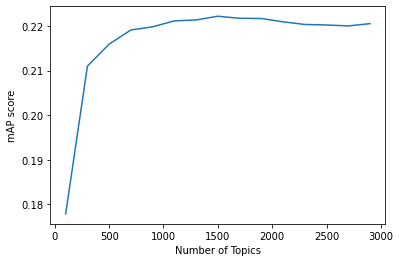

In [14]:
x=range(100,3000, 200)
plt.plot(x, map_value)
plt.xlabel('Number of Topics')
plt.ylabel('mAP score')
plt.show()

### Plot so sánh 3 tập train dev test

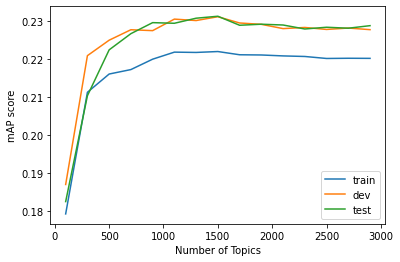

In [15]:
x=range(100,3000, 200)
plt.plot(x, map_value_train, label='train')
plt.plot(x, map_value_dev, label='dev')
plt.plot(x, map_value_test, label='test')
plt.legend()
plt.xlabel('Number of Topics')
plt.ylabel('mAP score')
plt.show()

In [20]:
np.max(map_value_test), np.max(map_value_dev)

(0.2313387121157705, 0.2312117146503147)

### Dev

In [8]:
docs, docs_title = load_data('./nfcorpus/dev/dev.docs')
queries, queries_title = load_data('./nfcorpus/dev/dev.all.queries')
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]
tfidf = gensim.models.TfidfModel(corpus, smartirs='npu')
corpus_tfidf = tfidf[corpus]
lsi = gensim.models.LsiModel(corpus_tfidf, num_topics=1500)
index = gensim.similarities.MatrixSimilarity(lsi[corpus_tfidf])

fqrel = open('./nfcorpus/dev/dev.3-2-1.qrel', 'r', encoding='utf-8')
qrel = []
for f in fqrel.readlines():
    content = f.replace('\t', ' ').replace('\n', '').split()
    qrel.append([content[0], content[2]])

groundtruth = [[] for i in range(len(queries))]
groundtruth_title = []
for i in qrel:
    if i[0] not in groundtruth_title:
        groundtruth_title.append(i[0])
    element = groundtruth_title.index(i[0])
    groundtruth[element].append(i[1])

all_rank = ranking(lsi, index, queries)
all_rank_title = docs_title[all_rank]
print(f'Kết quả MAP: {mAP(all_rank_title, groundtruth, groundtruth_title, queries_title)}')

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Kết quả MAP: 0.23034476355825317


Executed tf-idf time: 968.4999442100525


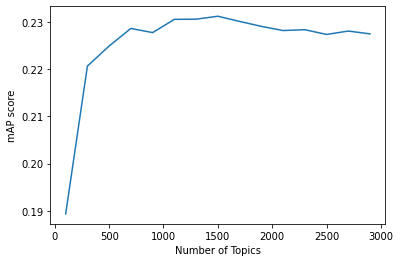

In [19]:
start_time = time.time()

map_value = []
for num_topic in range(100,3000, 200):
    model = gensim.models.LsiModel(corpus_tfidf, num_topics=num_topic)
    indexing = gensim.similarities.MatrixSimilarity(model[corpus_tfidf])
    all_rank = ranking(model, indexing, queries)
    all_rank_title = docs_title[all_rank]
    map_value.append(mAP(all_rank_title, groundtruth, groundtruth_title, queries_title))

print('Executed tf-idf time: {}'.format(time.time() - start_time))

x=range(100,3000, 200)
plt.plot(x, map_value)
plt.xlabel('Number of Topics')
plt.ylabel('mAP score')
plt.show()

### test

In [14]:
docs, docs_title = load_data('./nfcorpus/test/test.docs')
queries, queries_title = load_data('./nfcorpus/test/test.all.queries')
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]
tfidf = gensim.models.TfidfModel(corpus, smartirs='npu')
corpus_tfidf = tfidf[corpus]
lsi = gensim.models.LsiModel(corpus_tfidf, num_topics=1400)
index = gensim.similarities.MatrixSimilarity(lsi[corpus_tfidf])

fqrel = open('./nfcorpus/test/test.3-2-1.qrel', 'r', encoding='utf-8')
qrel = []
for f in fqrel.readlines():
    content = f.replace('\t', ' ').replace('\n', '').split()
    qrel.append([content[0], content[2]])

groundtruth = [[] for i in range(len(queries))]
groundtruth_title = []
for i in qrel:
    if i[0] not in groundtruth_title:
        groundtruth_title.append(i[0])
    element = groundtruth_title.index(i[0])
    groundtruth[element].append(i[1])

all_rank = ranking(lsi, index, queries)
all_rank_title = docs_title[all_rank]
print(f'Kết quả MAP: {mAP(all_rank_title, groundtruth, groundtruth_title, queries_title)}')

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Kết quả MAP: 0.22861376349254867


Executed tf-idf time: 624.6375017166138


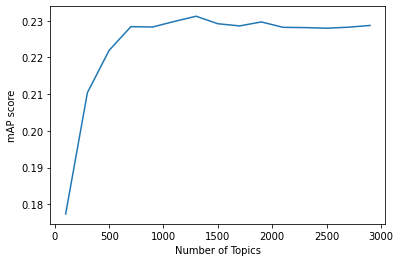

In [13]:
start_time = time.time()

map_value = []
for num_topic in range(100,3000, 200):
    model = gensim.models.LsiModel(corpus_tfidf, num_topics=num_topic)
    indexing = gensim.similarities.MatrixSimilarity(model[corpus_tfidf])
    all_rank = ranking(model, indexing, queries)
    all_rank_title = docs_title[all_rank]
    map_value.append(mAP(all_rank_title, groundtruth, groundtruth_title, queries_title))

print('Executed tf-idf time: {}'.format(time.time() - start_time))

x=range(100,3000, 200)
plt.plot(x, map_value)
plt.xlabel('Number of Topics')
plt.ylabel('mAP score')
plt.show()

In [15]:
np.max(map_value)

0.23123597153242018